# Interactive clustering APP

In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import ipywidgets as widgets
from IPython.display import display
import os

import matplotlib.pyplot as plt

## Load data

In [2]:
VaVaI_DataFrame = pd.read_csv('../data/TACR_Starfos_isvav_project.csv')
VaVaI_columns = VaVaI_DataFrame.columns.to_list()

## Define transforms

#### Preprocessing

In [3]:
# Preprocessing methods
import re
from string import punctuation
import nltk
from nltk.corpus import stopwords
import requests
from conllu import parse

def display_head(df):
    print('=========================================')
    for i in range(5):
        print(df[i][:100])
        print()

def remove_stopwords_eng(x):
    sw = stopwords.words('english')
    sw.extend(['aim', 'goal', 'attempt', 'project', 'evaluate', 'research', 'improve', 'improvement', 'development'])
    sw = set(sw)
    sw = sw.union(set(mc))
    new_sentence = []
    for word in x:
        word = word.lower()
        if word not in sw:
            new_sentence.append(word)
    return new_sentence

def tokenize_text(text):
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    return tokenizer.tokenize(text)

def lemmatize_text(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(w.lower()) for w in text]

def ud_tokenize_lemmatize(text):
    response = requests.get(f'http://lindat.mff.cuni.cz/services/udpipe/api/process?tokenizer&tagger&parser&data={text}').json()
    response = parse(response['result'])
    lemmas = []
    for sentence in response:
        lemmas.extend([word['lemma'] for word in sentence])
    return lemmas

#### Vectorization

##### - TF-IDF

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_using_tf_idf(data, min_n=1, max_n=5, results_dir=None):
    result = {}
    for i in range(min_n, max_n + 1):
        for j in range(min_n, max_n + 1):
            if i > j: continue
            print(f'Fitting TF-IDF for ngram range: ({i},{j})')
            transformer = TfidfVectorizer(ngram_range=(min_n, max_n))
            vectorized = transformer.fit_transform(data.apply(' '.join))
            result[f'tf-idf_({i},{j})'] = vectorized
    return result

##### - Word2Vec - Pretrained

In [5]:
import gensim
from gensim.models import Word2Vec
import gensim.downloader as api

model_names = ['fasttext-wiki-news-subwords-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50',
               'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 
               'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200']

def word2vec(data, model_name):
    def document_vector(sentence):
        if len(sentence) == 0:
            return np.zeros(model.vector_size)
        doc = [word for word in sentence if word in model]
        if len(doc) == 0:
            return np.zeros(model.vector_size)
        return np.mean(model[doc], axis=0)
    
    print(f'Loading model: {model_name}')
    model = api.load(model_name)
    vectorized = data.apply(document_vector)
    return np.stack(vectorized)

def vectorize_using_pretrained_word2vec(data):
    results = {}
    for model_name in model_names:
        vectorized = word2vec(data, model_name)
        results[f'word2vec_({model_name})'] = vectorized
    return results

/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


##### - Word2Vec

In [6]:
def word2vec_train(df, vector_size, epochs, results_dir):
    def document_vector(sentence):
        if len(sentence) == 0:
            return np.zeros(model.vector_size)
        doc = np.array([model.wv[word] for word in sentence])
        if len(doc) == 0:
            return np.zeros(model.vector_size)
        return np.mean(doc, axis=0)
    
    print(f'Training Word2Vec model with vector size {vector_size} for {epochs}')
    data = df.to_list()
    model = Word2Vec(sentences=data, vector_size=vector_size, window=5, min_count=1, workers=4, epochs=epochs)
    model.save(os.path.join(results_dir, f'word2vec_{vector_size}_{epochs}.model'))
    
    vectorized = df.apply(document_vector)
    return np.stack(vectorized)

def vectorize_using_word2vec(data, results_dir=None):
    results = {}
    for vs in [25, 50, 100, 200]:
        for ep in [5, 10, 25, 50]:
            vectorized = word2vec_train(data, vs, ep, results_dir)
            results[f'word2vec_{vs}_{ep}'] = vectorized
    return results

##### - Doc2Vec

In [7]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def doc2vec_train(data, vector_size, epochs, results_dir):
    print(f'Training Doc2Vec model with vector size {vector_size} for {epochs} epochs')
    model = Doc2Vec(documents=data, 
                    vector_size=vector_size, 
                    window=5, 
                    min_count=1, 
                    workers=8,
                    hs=1,
                    epochs=epochs)
    model.save(os.path.join(results_dir, f'doc2vec_{vector_size}_{epochs}.model'))
    return np.array([model.dv[i] for i in range(len(data))])

def vectorize_using_doc2vec(data, results_dir=None):
    results = {}
    tagged_data = [TaggedDocument(words=sentence, tags=[index]) for sentence, index in zip(data, list(data.index))]
    for vs in [25, 50, 100, 200]:
        for ep in [5, 10, 25, 50]:
            vectorized = doc2vec_train(tagged_data, vs, ep, results_dir)
            results[f'doc2vec_{vs}_{ep}'] = vectorized
    return results

#### FastText

In [8]:
from gensim.models import FastText

def fast_text_train(df, vector_size, epochs, results_dir):
    def document_vector(sentence):
        if len(sentence) == 0:
            return np.zeros(model.vector_size)
        doc = np.array([model.wv[word] for word in sentence])
        if len(doc) == 0:
            return np.zeros(model.vector_size)
        return np.mean(doc, axis=0)
    
    print(f'Training FastText model with vector size {vector_size} for {epochs}')
    data = df.to_list()
    model = FastText(sentences=data, vector_size=vector_size, window=5, min_count=10, workers=4, epochs=epochs)
    model.save(os.path.join(results_dir, f'fasttext_{vector_size}_{epochs}.model'))
    
    vectorized = df.apply(document_vector)
    return np.stack(vectorized)

def vectorize_using_fasttext(data, results_dir=None):
    results = {}
    for vs in [25, 50, 100, 200]:
        for ep in [5, 10, 25, 50]:
            vectorized = fast_text_train(data, vs, ep, results_dir)
            results[f'fasttext_{vs}_{ep}'] = vectorized
    return results

#### Evaluation

In [9]:
from pyclustertend import hopkins
import unidip.dip as dip
from sklearn.decomposition import PCA

def calc_hopkins_score(vector):
    if hasattr(vector, 'toarray'):
        vector = vector.toarray()
    df = pd.DataFrame(vector)
    hs = hopkins(df, 1000)
    return hs

def pca_dip(vector):
    def dip_test(v):
        pca = PCA(n_components=1, random_state=42)
        trans = pca.fit_transform(v).flatten()
        d = dip.diptst(trans)[1]
        return d
        
    if hasattr(vector, 'toarray'):
        vector = vector.toarray()
    return dip_test(vector)

def eval_using_hopkins_test(results_dir, results):
    data = defaultdict(list)
    with open(os.path.join(results_dir, 'hopkins.txt'), 'w') as handle:
        for name, vector in results.items():
            if 'tf-idf' in name:
                rand = np.random.randint(0, vector.shape[0], 1000)
                vector = vector[rand]
            hs = calc_hopkins_score(vector)
            d = pca_dip(vector)
            handle.write(f'Hopkins score for {name}: {hs:5f}\n')
            handle.write(f'Dip statisitc for {name}: {d:5f}\n')
            data['Hopkins'].append(hs)
            data['PCA-dip'].append(d)
    pd.DataFrame(data).to_csv(os.path.join(results_dir, 'metrics.csv'))

#### Cluster

In [10]:
from nltk.cluster import KMeansClusterer, euclidean_distance, cosine_distance
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

def cluster_using_kmeans(data, ax):
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(1, 40), ax=ax)
    visualizer.fit(data)

def visualize_kmeans_results(results_dir, results):
    height = len(results) * 20
    fig, axes = plt.subplots(len(results), figsize=(12, height))

    for idx, (name, vector) in enumerate(results.items()):
        print(f'Fitting elbow for {name}')
        cluster_using_kmeans(vector, axes[idx])
        axes[idx].set_title(f'KMeans Elbow for {name}')
        axes[idx].set_xticks(list(range(40)))

    plt.savefig(os.path.join(results_dir, 'kmeans_elbow.png'))

#### Widgets

In [11]:
# Data source
datasource_select = widgets.ToggleButtons(
    options=['Generate', 'Load'],
    description='Data:',
    disabled=False,
    button_style='',
    tooltips=['Load all projects and generate data', 'Load processed data from file'],
    icons=['check'] * 2)
data_source_widget = widgets.HBox([datasource_select])

# Columns
multisel_columns = widgets.SelectMultiple(
    options=VaVaI_columns,
    disabled=False,
    rows=20,
)
col_select_button = widgets.Button(description='Select column(s)', icon='table')
columns_widget = widgets.VBox([multisel_columns, col_select_button])

# Transforms
transforms = {
    'Tokenize': tokenize_text,
    'Lemmatize': lemmatize_text,
    'Remove stopwords': remove_stopwords_eng,
    'UDPipe': ud_tokenize_lemmatize
}
multisel_transforms = widgets.SelectMultiple(
    options=list(transforms.keys()),
    disabled=False,
    rows=10,
)
trans_select_button = widgets.Button(description='Select Transforms', icon='table')
trans_widget = widgets.VBox([multisel_transforms, trans_select_button])

# Models
models = {
    'TF-IDF': vectorize_using_tf_idf,
    'Word2Vec-Pretrained': vectorize_using_pretrained_word2vec,
    'Word2Vec': vectorize_using_word2vec,
    'FastText': vectorize_using_fasttext,
    'Doc2Vec': vectorize_using_doc2vec
}
multisel_models = widgets.SelectMultiple(
    options=list(models.keys()),
    disabled=False,
    rows=10,
)
model_select_button = widgets.Button(description='Select Models', icon='table')
model_widget = widgets.VBox([multisel_models, model_select_button])

selections_widget = widgets.HBox([columns_widget, trans_widget, model_widget])

widgets.VBox([data_source_widget, selections_widget])

In [ ]:
import pickle
from stop_words import get_stop_words
import re
from string import punctuation
from collections import defaultdict, Counter

RESULTS_DIR = 'tf_w2v_d2v_fast_cz_nolemma_naz_anot_obor_uc_res_pos_2'

if datasource_select.value == 'Generate': 
    selected_columns = list(multisel_columns.value)
    selected_columns_df = VaVaI_DataFrame[selected_columns]
    
    # Clean the data
    nan_rows = selected_columns_df.isna().any(axis=1)
    cleaned_df = selected_columns_df[~nan_rows]

    # Pair with the original df for future reference
    VaVaI_DataFrame = VaVaI_DataFrame.iloc[cleaned_df.index]
    cleaned_df.reset_index(inplace=True, drop=True)
    VaVaI_DataFrame.reset_index(inplace=True, drop=True)
    display(cleaned_df.head())
    print(f'Number of rows after cleaning: {len(cleaned_df)}')

    del selected_columns_df
    processed_data = cleaned_df.apply(' '.join, axis=1).astype(str)
    
    print(f'Applying transforms {multisel_transforms.value}')
    for transform_name in multisel_transforms.value:
        print(f'Processing... {transform_name}')
        if transform_name == 'Remove stopwords':
            counts = Counter(' '.join(processed_data.apply(' '.join)).split())
            mc = set([t[0] for t in counts.most_common(200)])
        processed_data = processed_data.apply(transforms[transform_name])
        display_head(processed_data)
        
else:
    df = pd.read_csv('../data/nazev_anotace_lemmatized.csv')
    processed_data = df['text']
    processed_data = processed_data.apply(lambda x: re.sub('\'', '', x))\
                                   .apply(lambda x: re.sub('\s', '', x))\
                                   .apply(lambda x: x[1:-1].split(','))

    sw = get_stop_words('cz')
    sw += get_stop_words('en')
    sw = set(sw)

    def remove_punctuation(arr):
        return [w for w in arr if w not in punctuation]

    def remove_stopwords(arr, mc):
        ssw = sw.union(mc)
        return [w for w in arr if w not in ssw]
            
    processed_data = processed_data.apply(remove_punctuation)
    concat = ' '.join(processed_data.apply(' '.join).str.replace('[0-9]', ''))
    from collections import Counter
    counts = Counter(concat.split())

    most_common = set([t[0] for t in counts.most_common(100)])
    processed_data = processed_data.apply(lambda x: remove_stopwords(x, most_common))

selected_models = list(multisel_models.value)
print(f'Using models: {selected_models}')

save_dir = os.path.join('saved_models', RESULTS_DIR)
os.makedirs(save_dir, exist_ok=True)

results = {}
for model in selected_models:
    results = {**results, **models[model](processed_data, results_dir=save_dir)}

with open(os.path.join(save_dir, 'vectors.pickle'), 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
eval_using_hopkins_test(save_dir, results)

,Název česky,Anotace česky,Hlavní CEP obor,Podrobné informace o účastnících,Hlavní řešitelé,Poskytovatel
0,"Frekvence a distribuce inzulinorezistence, jak...",Stanovení jednoduchých kvantitativních indexů ...,"FB - Endokrinologie, diabetologie, metabolismu...",Univerzita Palackého v Olomouci / Lékařská fak...,prof. MUDr. Vladimír Janout CSc. (vedidk=25123...,MZ - Ministerstvo zdravotnictví
1,13 let jako významný milník v životě dětí - ep...,Budou šetřeny výzkumné děti ve 13 letech jejic...,FM - Hygiena,Masarykova univerzita / Lékařská fakulta (ico:...,MUDr. Lubomír Kukla CSc. (vedidk=5814871),MZ - Ministerstvo zdravotnictví
2,Modely financování opatření k ochraně životníh...,Navrhnout model financování aspektů životního ...,AH - Ekonomie,Allowance s.r.o. (ico: 26140136; forma: POO - ...,Mgr. Drahomír Mezr (vedidk=6748791),MŽP - Ministerstvo životního prostředí
3,Ověření účinnosti dobrovolných nástrojů ochran...,Dosažení cílů udržitelného rozvoje a kvality ž...,"DM - Tuhý odpad a jeho kontrola, recyklace",ČESKÉ EKOLOGICKÉ MANAŽERSKÉ CENTRUM (ico: 4524...,PhDr. Věra Havránková (vedidk=3579417),MŽP - Ministerstvo životního prostředí
4,Aplikace environmentálního účetnictví na mikro...,Projekt řeší problematiku udržitelného rozvoje...,EH - Ekologie – společenstva,ČESKÉ EKOLOGICKÉ MANAŽERSKÉ CENTRUM (ico: 4524...,Ing. Jiří Študent (vedidk=5621542),MŽP - Ministerstvo životního prostředí


Number of rows after cleaning: 30554
Applying transforms ('Tokenize', 'Remove stopwords')
Processing... Tokenize
['Frekvence', 'a', 'distribuce', 'inzulinorezistence,', 'jako', 'rizikového', 'faktoru', 'kardiovaskulárních', 'a', 'metabolických', 'onemocněni', 'Stanovení', 'jednoduchých', 'kvantitativních', 'indexů', 'HOMA-IR', 'a', 'QUICKI', 'u', 'skupin', 'osob', 's', 'intolerancí', 'glukózy,diabetem', 'typu', '2,', 'hyperlipidémií,', 'obezitou,', 'hypertenzí,', 'kombinací', 'faktorů', 've', 'srovnání', 'se', 'zdravými', 'jedinci', 'pro', 'posouzení', 'časného', 'stádia', 'inzulínové', 'rezistencePokus', 'o', 'stanovení', 'hraniční', 'hodnoty,', 'která', 'by', 'odlišovala', 'osoby', 's', 'rizikem', 'inzulínové', 'rezistence', 'a', 'osoby', 'bez', 'rizika.', 'FB', '-', 'Endokrinologie,', 'diabetologie,', 'metabolismus,', 'výživa', 'Univerzita', 'Palackého', 'v', 'Olomouci', '/', 'Lékařská', 'fakulta', '(ico:', '61989592;', 'forma:', 'VVS', '-', 'Veřejná', 'nebo', 'státní', 'vysoká', 'š

Fitting TF-IDF for ngram range: (1,2)
Fitting TF-IDF for ngram range: (1,3)
Fitting TF-IDF for ngram range: (1,4)
Fitting TF-IDF for ngram range: (1,5)
Fitting TF-IDF for ngram range: (2,2)
Fitting TF-IDF for ngram range: (2,3)
Fitting TF-IDF for ngram range: (2,4)
Fitting TF-IDF for ngram range: (2,5)
Fitting TF-IDF for ngram range: (3,3)
Fitting TF-IDF for ngram range: (3,4)
Fitting TF-IDF for ngram range: (3,5)
Fitting TF-IDF for ngram range: (4,4)
Fitting TF-IDF for ngram range: (4,5)
Fitting TF-IDF for ngram range: (5,5)
Training Word2Vec model with vector size 25 for 5
Training Word2Vec model with vector size 25 for 10
Training Word2Vec model with vector size 25 for 25
Training Word2Vec model with vector size 25 for 50
Training Word2Vec model with vector size 50 for 5
Training Word2Vec model with vector size 50 for 10
Training Word2Vec model with vector size 50 for 25
Training Word2Vec model with vector size 50 for 50
Training Word2Vec model with vector size 100 for 5
Training Wo

In [57]:
counts.most_common(200)

[('a', 101984),
 ('-', 64776),
 ('v', 49271),
 ('na', 27966),
 ('(ico:', 26182),
 ('forma:', 26182),
 ('adresa:', 26182),
 ('Česko)', 25161),
 ('pro', 21349),
 ('je', 18802),
 ('s', 18439),
 ('Veřejná', 15222),
 ('00', 12302),
 ('nebo', 11559),
 ('projektu', 11559),
 ('se', 11240),
 ('bude', 10901),
 ('Ing.', 10406),
 ('v.', 10003),
 ('ČR', 9707),
 ('státní', 9592),
 ('Ministerstvo', 9569),
 ('vysoká', 9386),
 ('VVS', 9296),
 ('škola;', 9296),
 ('/', 9012),
 ('k', 8572),
 ('České', 8289),
 ('Praha', 8194),
 ('z', 7812),
 ('budou', 6952),
 ('jejich', 6873),
 ('osoba', 6818),
 ('ve', 6767),
 ('Ph.D.', 6701),
 ('i', 6642),
 ('Právnická', 6600),
 ('obchodním', 6548),
 ('POO', 6532),
 ('zapsaná', 6532),
 ('rejstříku;', 6532),
 ('AV', 6130),
 ('výzkumná', 6105),
 ('VVI', 5927),
 ('instituce;', 5924),
 ('CSc.', 5535),
 ('agentura', 5440),
 ('o', 5428),
 ('do', 5288),
 ('ČR,', 5241),
 ('republiky', 5010),
 ('i.', 5002),
 ('které', 4983),
 ('Cílem', 4817),
 ('Město,', 4436),
 ('mládeže', 4205),

In [20]:
import gensim.downloader as api

In [22]:
api.load('a')

ValueError: Incorrect model/corpus name

In [18]:
ft = fasttext.load_model('cc.cs.300.bin')
ft.get_dimension()

ValueError: cc.cs.300.bin cannot be opened for loading!

FileUpload(value={}, description='Upload data:')


## Filter columns

In [3]:
multisel_columns = widgets.SelectMultiple(
    options=VaVaI_columns,
    disabled=False,
    rows=20,
)

select_button = widgets.Button(description='Select column(s)', icon='table')
columns_widget = widgets.VBox([multisel_columns, select_button])

,Název česky,Anotace česky
0,Účast neuroaktivních steroidů na mužské reprod...,Předmětem projektu je studium účasti neuroakti...
1,Zkvalitnění péče o pacienty s cystickou fibróz...,Cílem je ověření efektivity (proveditelnosti a...
2,Molekulárně cytogenetická analýza buněk mozkov...,Molekulárně cytogenetická studie signifikantní...
3,Modelování potenciálně antimykobakteriálně akt...,Syntéza nových potenciálně antimykobakteriálně...
4,Rozvoj aplikací DNA čipů pro potřeby diagnosti...,Aplikace DNA čipů by měly významným způsobem p...


## Preprocess data
- concat
- convert to lowercase
- remove punctuation
- tokenize
- remove stop-words

In [16]:
df = pd.read_csv('nazev_anotace_lemmatized.csv')

,Unnamed: 0,text
0,0,"['účast', 'uroaktivní', 'steroid', 'na', 'mužs..."
1,1,"['zkvalitnění', 'péče', 'o', 'pacient', 's', '..."
2,2,"['molekulárně', 'cytogenetický', 'analýza', 'b..."
3,3,"['modelování', 'potenciálně', 'antimykobakteri..."
4,4,"['rozvoj', 'aplikace', 'DNA', 'čip', 'pro', 'p..."
...,...,...
53394,53394,"['obnova', 'biodiverzita', 'a', 'stabilita', '..."
53395,53395,"['geodynamický', 'model', 'styk', 'český', 'ma..."
53396,53396,"['vývoj', 'zemský', 'kůra', 'v', 'západní', 'č..."
53397,53397,"['využití', 'moderní', 'letecký', 'metoda', 'p..."


In [ ]:
import pickle

selected_models = list(multisel_models.value)
print(selected_models)
sampled_data = processed_data.sample(n=1000, random_state=42)

results = {}
for model in selected_models:
    results = {**results, **models[model](processed_data)}
    
with open('vectors.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

['TF-IDF', 'Word2Vec', 'Doc2Vec']
Fitting TF-IDF for ngram range: (1,1)
Fitting TF-IDF for ngram range: (1,2)
Fitting TF-IDF for ngram range: (1,3)
Fitting TF-IDF for ngram range: (1,4)
Fitting TF-IDF for ngram range: (1,5)
Fitting TF-IDF for ngram range: (2,2)
Fitting TF-IDF for ngram range: (2,3)
Fitting TF-IDF for ngram range: (2,4)
Fitting TF-IDF for ngram range: (2,5)
Fitting TF-IDF for ngram range: (3,3)
Fitting TF-IDF for ngram range: (3,4)
Fitting TF-IDF for ngram range: (3,5)
Fitting TF-IDF for ngram range: (4,4)
Fitting TF-IDF for ngram range: (4,5)
Fitting TF-IDF for ngram range: (5,5)
Training Word2Vec model with vector size 25 for 10
Training Word2Vec model with vector size 25 for 25
Training Word2Vec model with vector size 25 for 50
Training Word2Vec model with vector size 25 for 100
Training Word2Vec model with vector size 50 for 10
Training Word2Vec model with vector size 50 for 25
Training Word2Vec model with vector size 50 for 50
Training Word2Vec model with vector si

In [35]:
#TODO: remove this cell after testing
model = Doc2Vec.load('word2vec_200')

print(processed_data[0])
vec = model.infer_vector(processed_data[0])

similar = model.docvecs.most_similar([vec])

display(similar)

['frekvence', 'distribuce', 'inzulinorezistence', 'jako', 'rizikového', 'faktoru', 'kardiovaskulárních', 'metabolických', 'onemocněni', 'stanovení', 'jednoduchých', 'kvantitativních', 'indexů', 'homa', 'ir', 'quicki', 'u', 'skupin', 'osob', 'intolerancí', 'glukózy', 'diabetem', 'typu', '2', 'hyperlipidémií', 'obezitou', 'hypertenzí', 'kombinací', 'faktorů', 'srovnání', 'se', 'zdravými', 'jedinci', 'pro', 'posouzení', 'časného', 'stádia', 'inzulínové', 'rezistencepokus', 'stanovení', 'hraniční', 'hodnoty', 'která', 'odlišovala', 'osoby', 'rizikem', 'inzulínové', 'rezistence', 'osoby', 'bez', 'rizika', 'fb', 'endokrinologie', 'diabetologie', 'metabolismus', 'výživa', 'univerzita', 'palackého', 'v', 'olomouci', 'lékařská', 'fakulta', 'parent', 'ičo', '61989592', 'prof', 'mudr', 'vladimír', 'janout', 'csc', 'vedidk', '2512343', 'orcid', '0000', '0002', '1163', '0361', 'mz', 'ministerstvo', 'zdravotnictví']


AttributeError: 'Word2Vec' object has no attribute 'infer_vector'

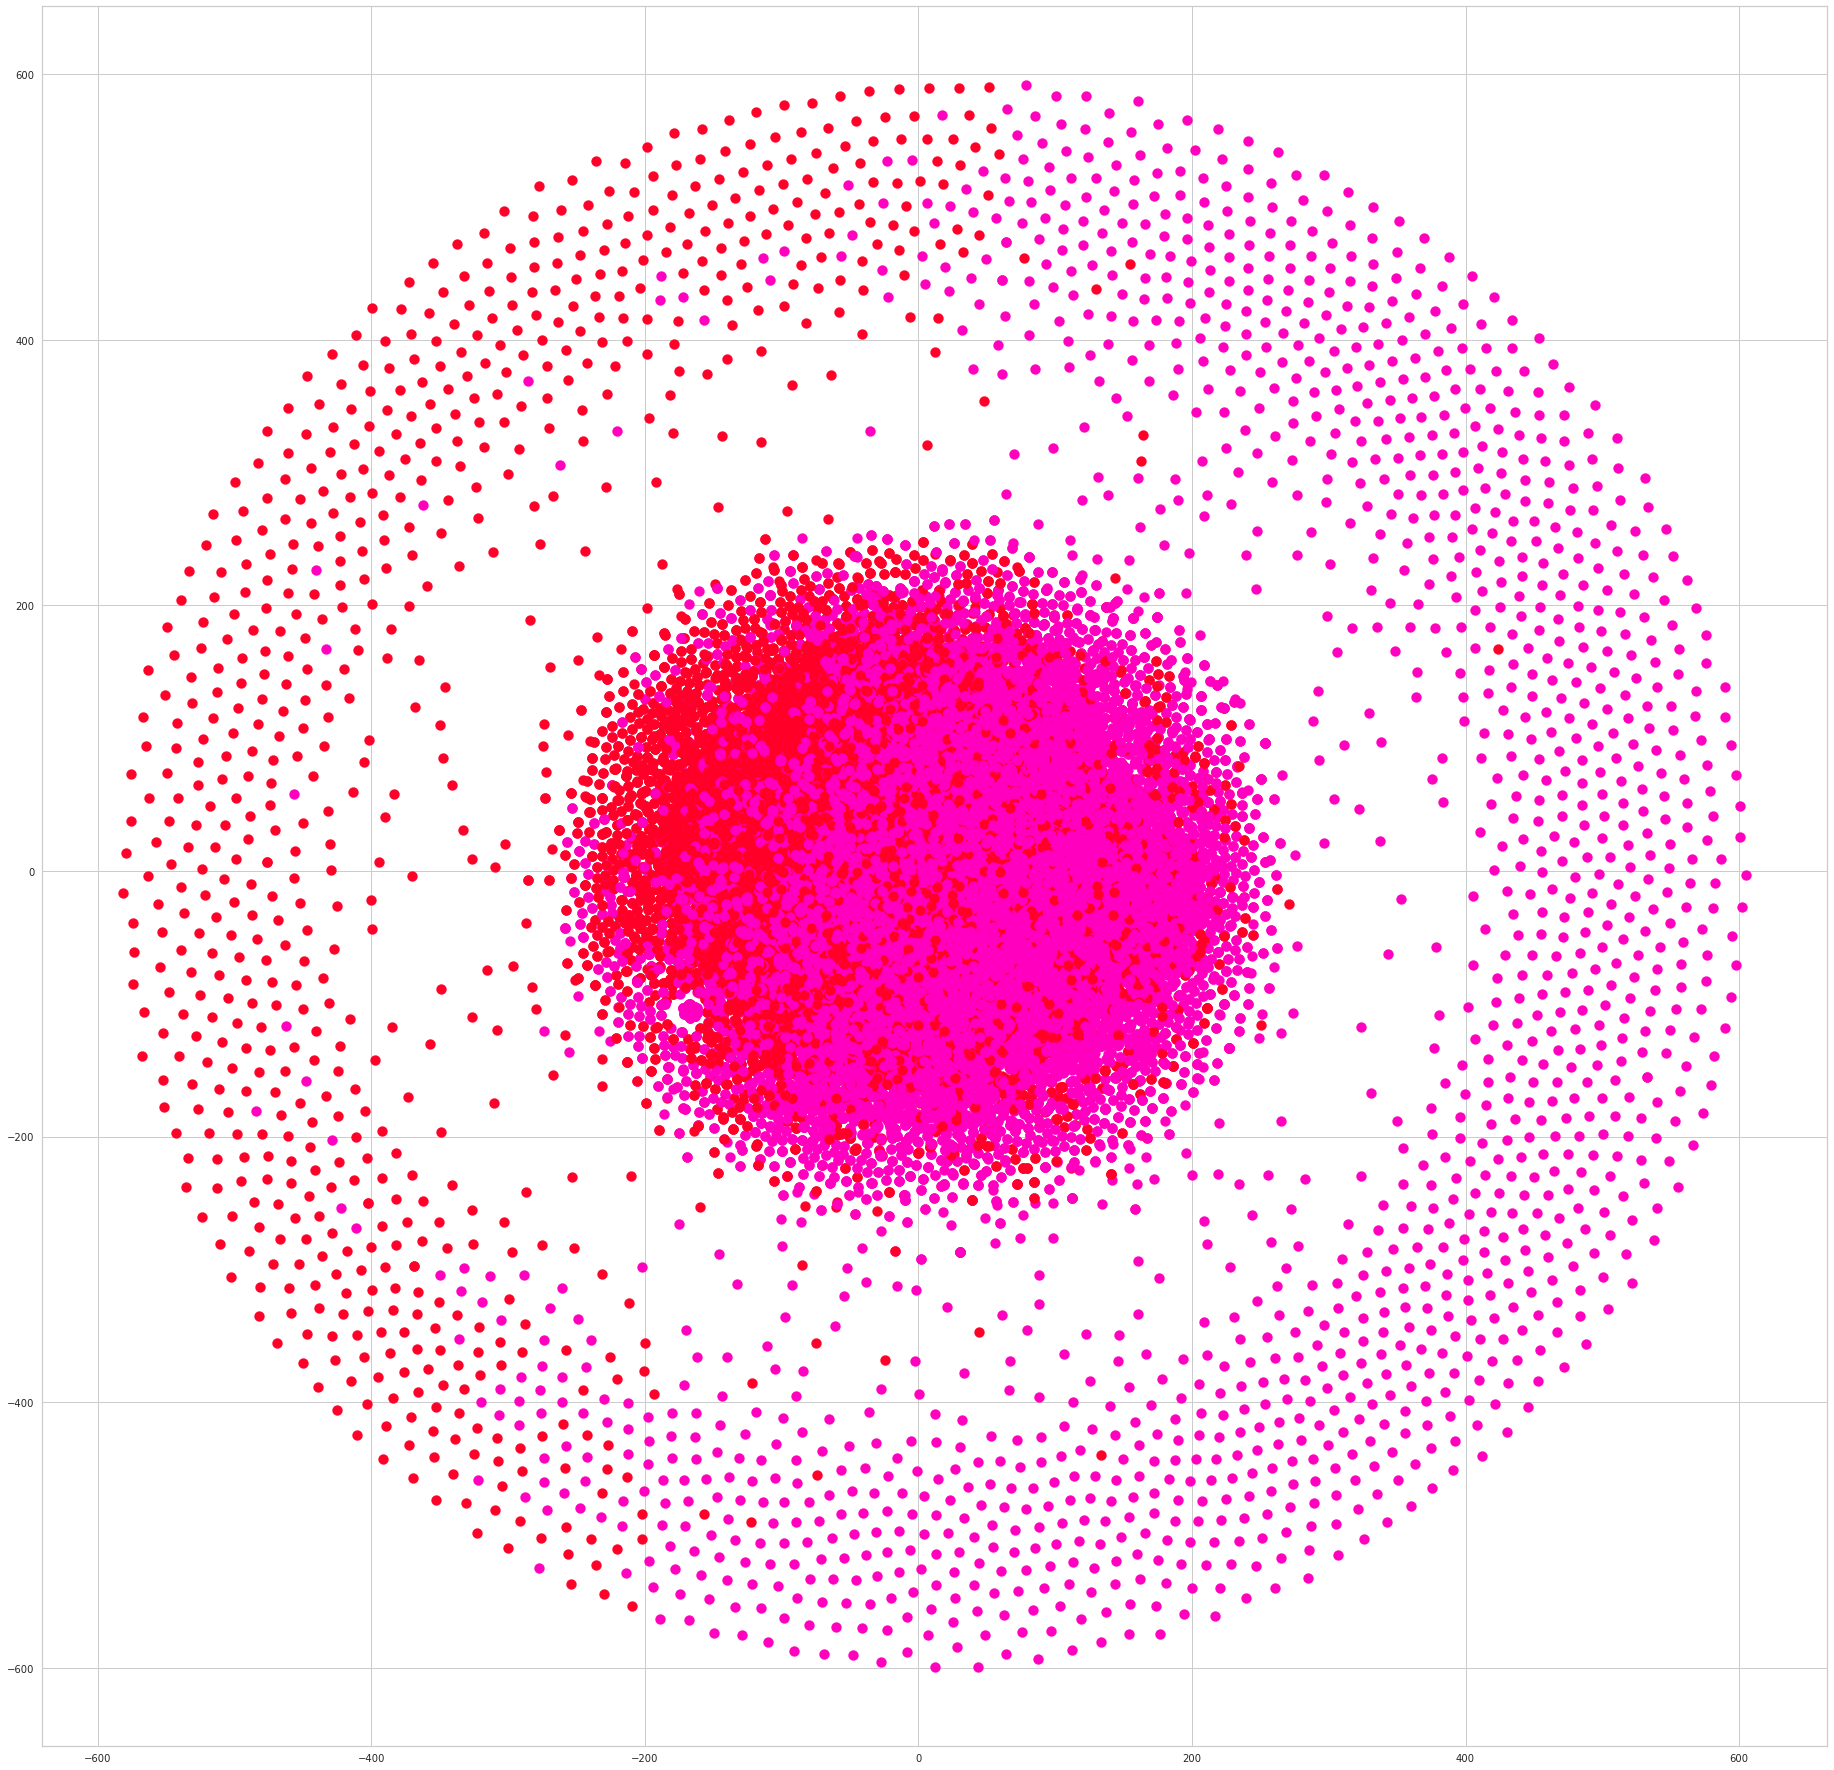

In [78]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm

def visualize_clusters(vector, n_classes):
    z = np.arange(n_classes)
    ys = [i+z+(i*z)**2 for i in range(n_classes)]
    colors = cm.gist_rainbow(np.linspace(0, 1, len(ys)))
    
    clusterer = KMeansClusterer(n_classes, euclidean_distance)
    clustered = clusterer.cluster(vector, assign_clusters=True)
    
    tsne_model = TSNE(perplexity=5, n_components=2, init='pca', n_iter=25000, random_state=23, n_jobs=-1)
    tsne_clusters = tsne_model.fit_transform(vector)
    
    x = []
    y = []
    for value in tsne_clusters:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(32, 32)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i], color=colors[clustered[i]], s=100)
    
visualize_clusters(results['doc2vec_100_100'], 2)

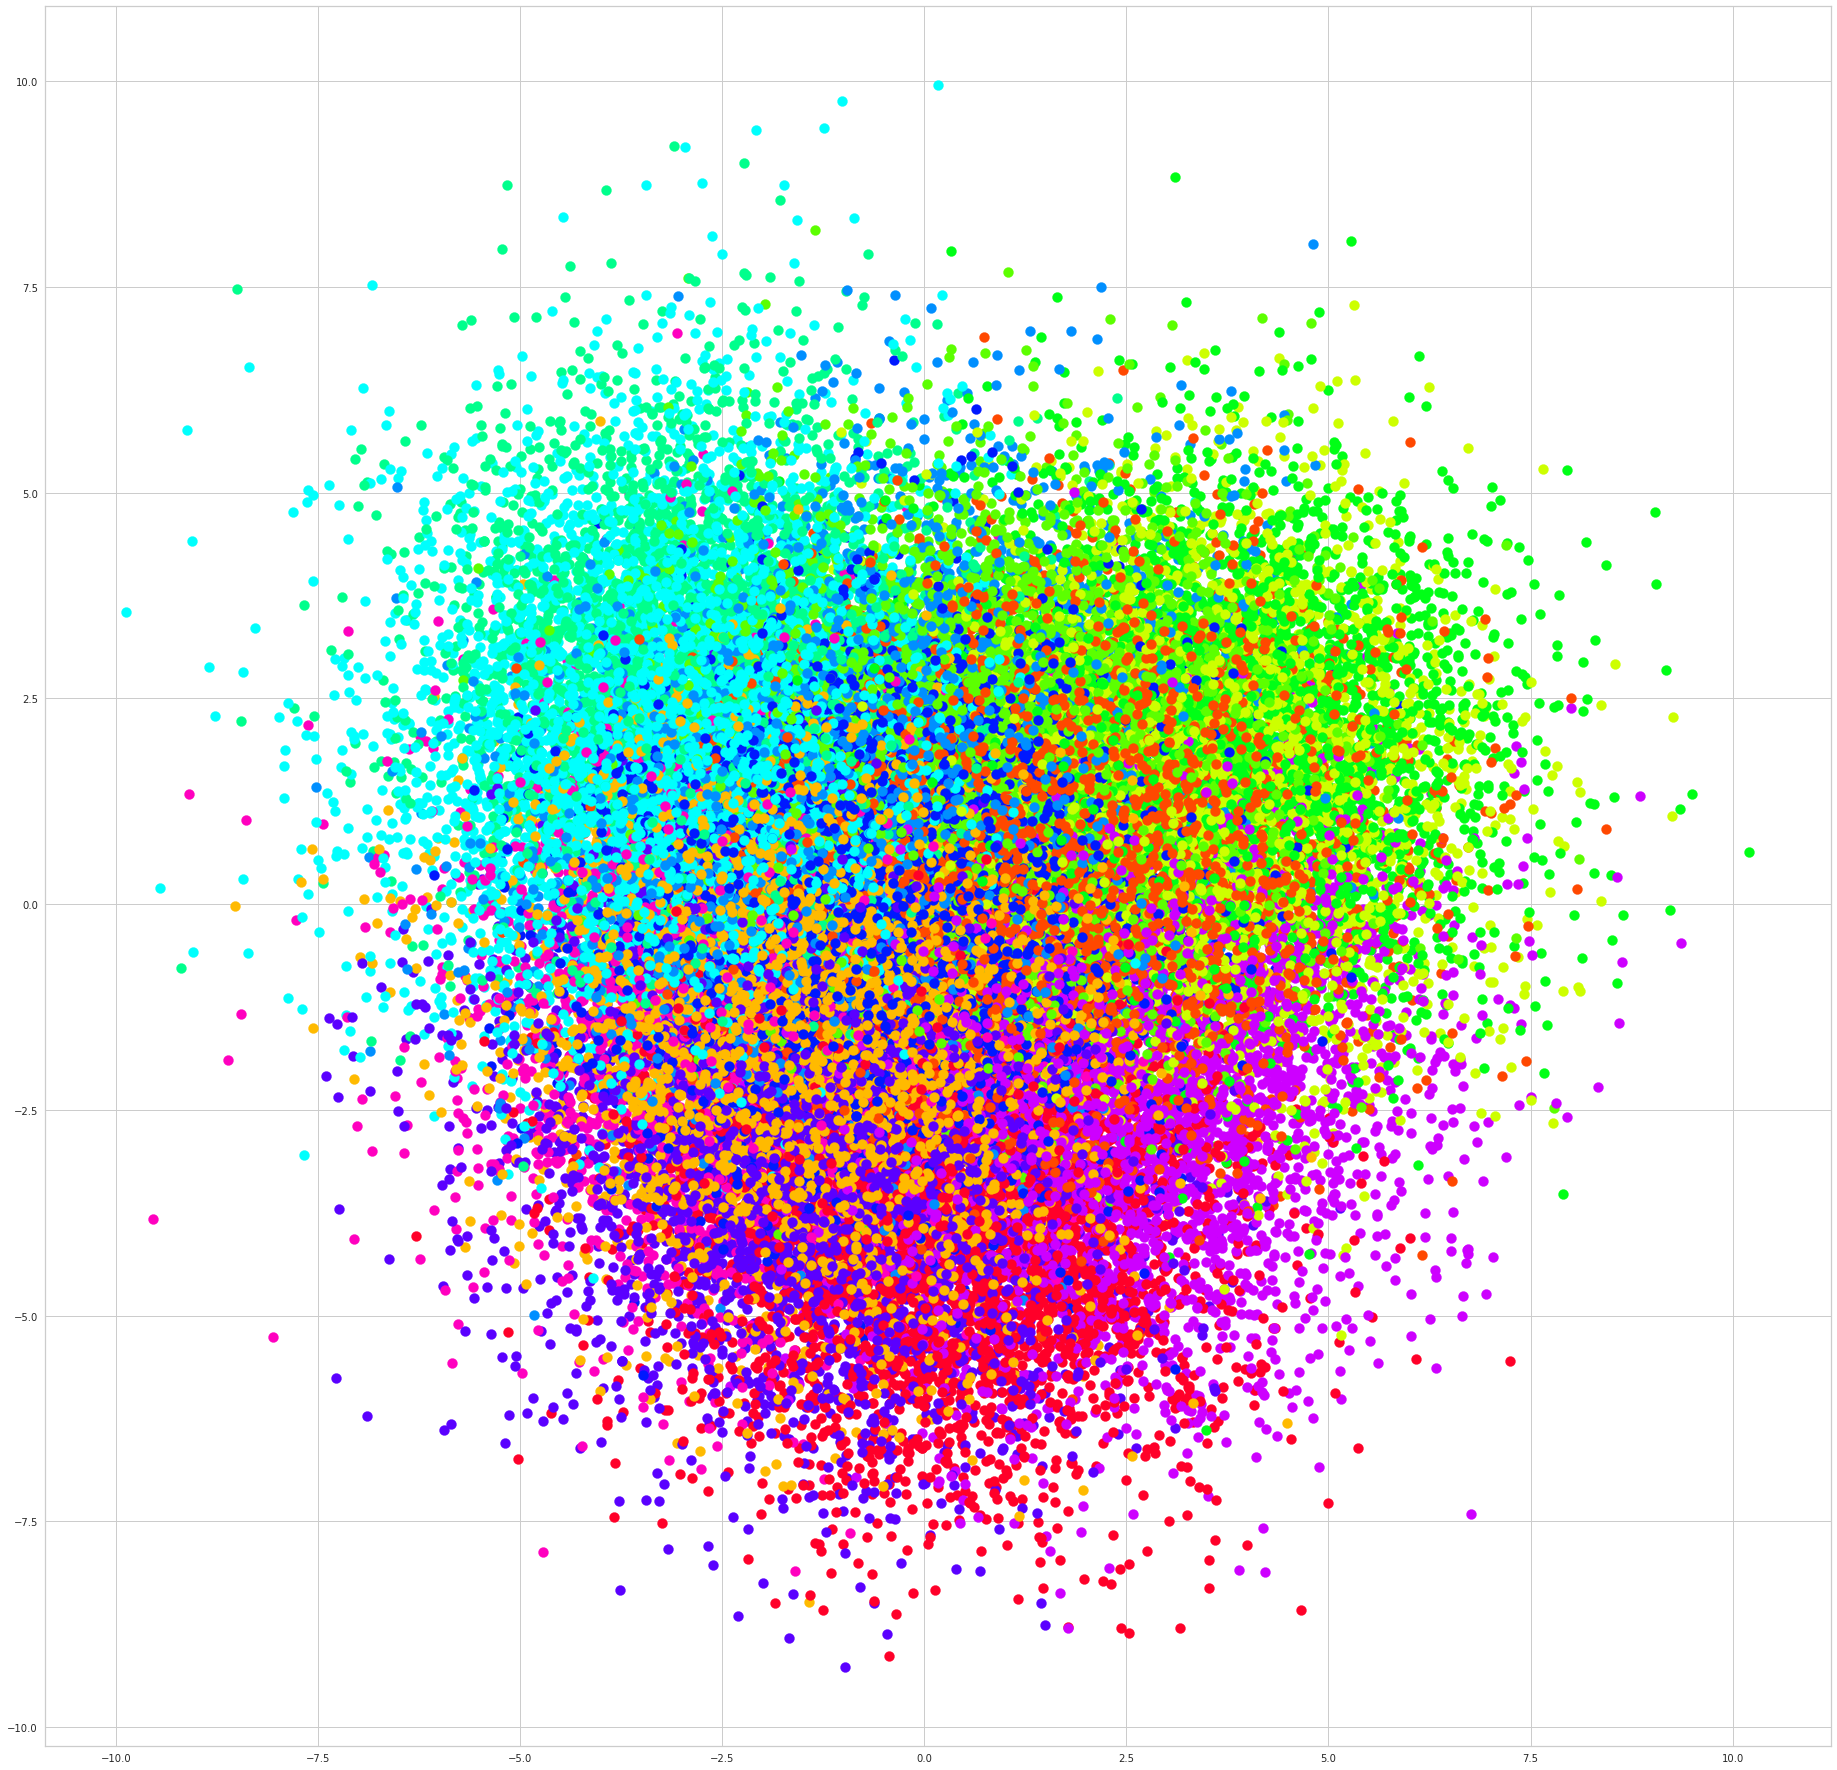

In [77]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.cm as cm

vector = results['doc2vec_100_100']
n_classes = 13
z = np.arange(n_classes)
ys = [i+z+(i*z)**2 for i in range(n_classes)]
colors = cm.gist_rainbow(np.linspace(0, 1, len(ys)))

clusterer = KMeansClusterer(n_classes, euclidean_distance)
clustered = clusterer.cluster(vector, assign_clusters=True)

tsne_model = PCA(n_components=2)
tsne_clusters = tsne_model.fit_transform(vector)

x = []
y = []
for value in tsne_clusters:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(32, 32)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i], color=colors[clustered[i]], s=100)


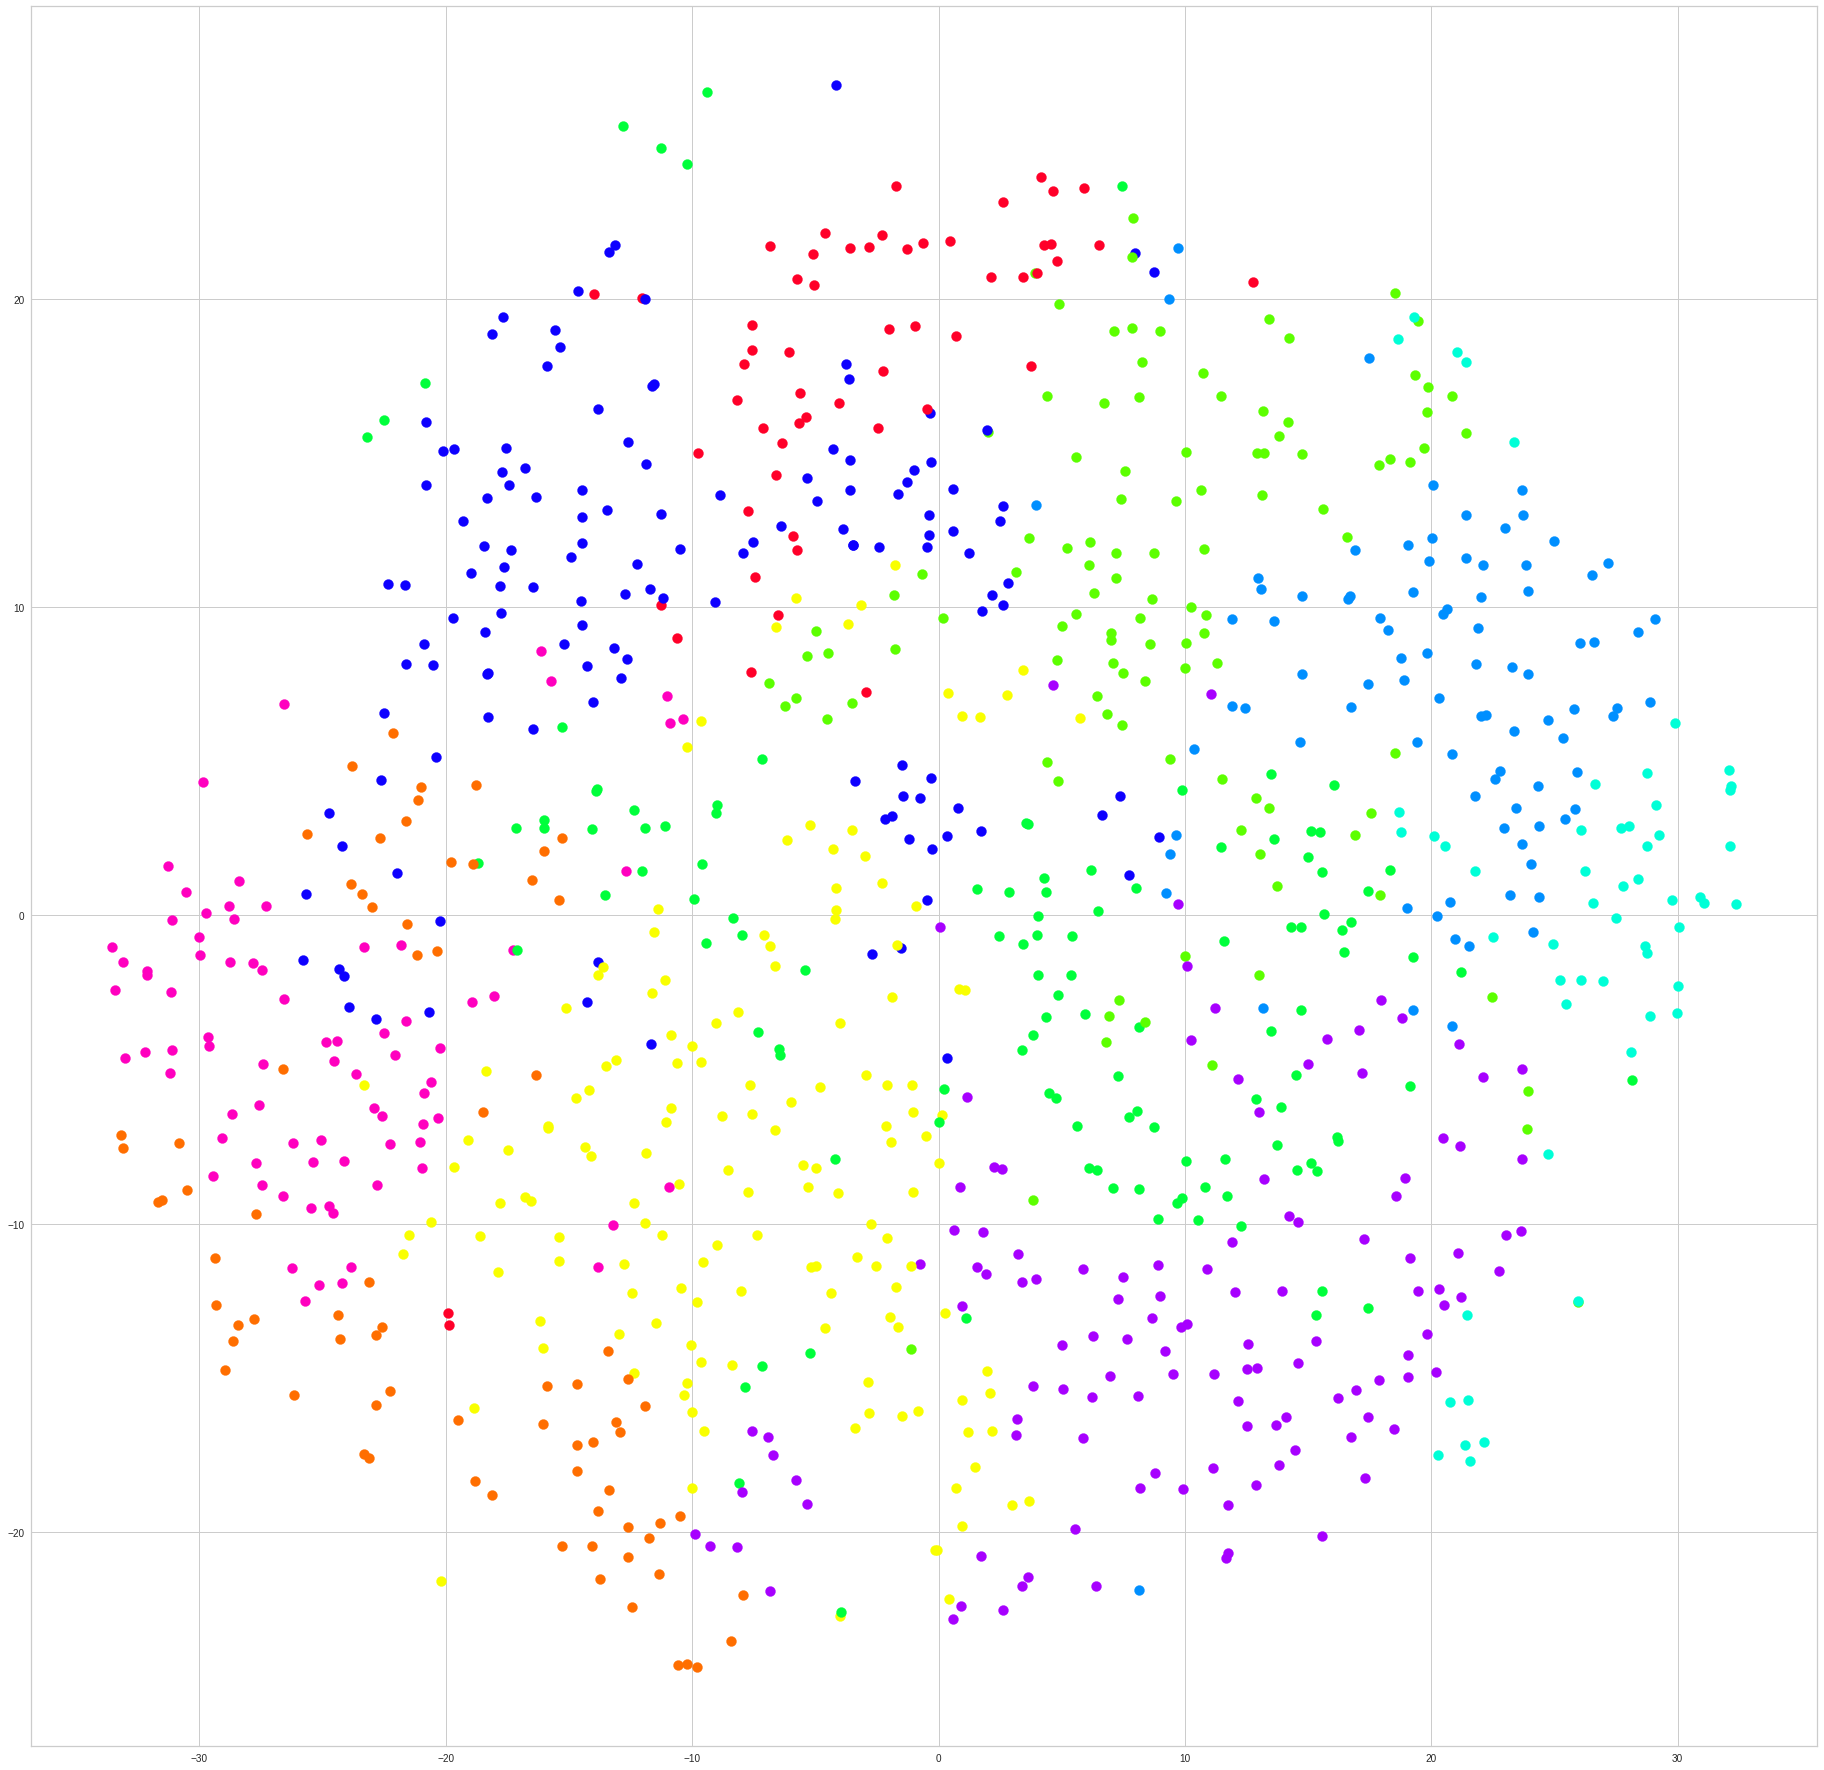

In [115]:
visualize_clusters(res[multisel_models.value])

In [28]:
import pickle
with open('saved_models/ud_pipe_czech_text/vectors.pickle', 'rb') as handle:
    vectors = pickle.load(handle)

In [22]:
from sklearn.cluster import AffinityPropagation
sample = vectors['word2vec_25_100'][np.random.choice(vectors['word2vec_25_100'].shape[0], 10000, replace=False), :]
clustering = AffinityPropagation(random_state=42, damping=0.9).fit(sample)

len(clustering.cluster_centers_)
KElbowVisualizer()

319

In [34]:
import pickle
with open('saved_models/w2v_d2v_kwords_lemmatize/vectors.pickle', 'rb') as handle:
    vectors = pickle.load(handle)

In [ ]:
def fast_text_train(df, vector_size, epochs):
    def document_vector(sentence):
        if len(sentence) == 0:
            return np.zeros(model.vector_size)
        doc = np.array([model.wv[word] for word in sentence])
        if len(doc) == 0:
            return np.zeros(model.vector_size)
        return np.mean(doc, axis=0)
    
    print(f'Training Word2Vec model with vector size {vector_size} for {epochs}')
    data = df.to_list()
    model = FastText(sentences=data, vector_size=vector_size, window=5, min_n=2 min_count=10, workers=4, epochs=epochs)
    model.save(f'word2vec_{vector_size}_{epochs}')
    
    vectorized = df.apply(document_vector)
    return np.stack(vectorized)

In [122]:
import pandas as pd
import numpy as np
import re
from string import punctuation
from stop_words import get_stop_words

In [84]:
df = pd.read_csv('../data/nazev_anotace_lemmatized.csv')
processed_data = df['text']
processed_data = processed_data.apply(lambda x: re.sub('\'', '', x))\
                               .apply(lambda x: re.sub('\s', '', x))\
                               .apply(lambda x: x[1:-1].split(','))

sw = get_stop_words('cz')
sw += get_stop_words('en')
sw = set(sw)

def remove_punctuation(arr):
    return [w for w in arr if w not in punctuation]
    
def remove_stopwords(arr, mc):
    ssw = sw.union(mc)
    return [w for w in arr if w not in ssw]

In [85]:
processed_data = processed_data.apply(remove_punctuation)

In [101]:
concat = ' '.join(processed_data.apply(' '.join).str.replace('[0-9]', ''))
from collections import Counter
counts = Counter(concat.split())
        
most_common = set([t[0] for t in counts.most_common(100)])
processed_data = processed_data.apply(lambda x: remove_stopwords(x, most_common))
processed_data

0        [účast, uroaktivní, steroid, mužský, reprodukc...
1        [zkvalitnění, péče, pacient, cystický, fibróza...
2        [molekulárně, cytogenetický, mozkový, tumor, p...
3        [modelování, potenciálně, antimykobakteriálně,...
4        [DNA, čip, potřeba, diagnostika, patogenese, l...
                               ...                        
53394    [obnova, biodiverzita, stabilita, lesní, ekosy...
53395    [geodynamický, styk, masiv, západní, Karpaty, ...
53396    [zemský, kůra, západní, Čechy, proterozoika, p...
53397    [moderní, letecký, hodnocení, zátěž, životní, ...
53398    [komplexní, zhodnocení, geofaktor, životní, ji...
Name: text, Length: 53399, dtype: object

In [115]:
data = processed_data.to_numpy()
vector_size = 100
model = FastText(sentences=data, vector_size=vector_size, window=5, min_count=10, workers=4)

In [118]:
model.wv.most_similar('genetika')

[('epigenetika', 0.9421475529670715),
 ('fylogenetika', 0.9346950650215149),
 ('cytogenetika', 0.8899424076080322),
 ('genomika', 0.8871620893478394),
 ('fenogenomika', 0.8449202179908752),
 ('metagenomika', 0.8287765383720398),
 ('genetic', 0.8282773494720459),
 ('geneta', 0.824867308139801),
 ('fylogenetický', 0.8028830289840698),
 ('genetický', 0.7882004380226135)]

In [119]:
model.wv.most_similar('doprava')

[('dopravce', 0.9366820454597473),
 ('oprava', 0.9006492495536804),
 ('dopravně', 0.8731725215911865),
 ('dopravník', 0.8715996146202087),
 ('náprava', 0.8693037033081055),
 ('přeprava', 0.8578541278839111),
 ('dopravní', 0.8400663137435913),
 ('opravdu', 0.8208562135696411),
 ('p°ýprava', 0.7895740866661072),
 ('údržba', 0.7329211235046387)]

In [124]:
def document_vector(sentence):
    if len(sentence) == 0:
        return np.zeros(model.vector_size)
    doc = np.array([model.wv[word] for word in sentence])
    if len(doc) == 0:
        return np.zeros(model.vector_size)
    return np.mean(doc, axis=0)

In [125]:
vectorized = processed_data.apply(document_vector)
vectorized

0        [-0.2302037, -0.24571604, 0.14663397, 0.312826...
1        [0.33516786, -0.51714754, 0.6355906, 0.7698612...
2        [0.28284156, -0.85979337, 0.834115, 0.7817186,...
3        [-0.028887184, -0.18613577, 0.5547219, 0.17894...
4        [0.35298413, -0.63132435, 0.8862958, 0.8665144...
                               ...                        
53394    [0.5630983, -0.04363914, -0.35328424, 0.322742...
53395    [0.81261176, -0.09857742, 0.94263536, 0.531706...
53396    [0.7954229, -0.0370101, 1.0343055, 0.27897456,...
53397    [0.5152584, -0.69765615, 1.310738, 0.30338246,...
53398    [0.7577235, -0.45291865, 1.020048, 0.39495245,...
Name: text, Length: 53399, dtype: object

In [129]:
model.wv.similar_by_vector(vectorized[0])

[('prognostický', 0.8509899377822876),
 ('imunodiagnostický', 0.8497047424316406),
 ('psychodiagnostický', 0.8205058574676514),
 ('imunopatologický', 0.8155838847160339),
 ('maligní', 0.8069888949394226),
 ('diagnostický', 0.80047208070755),
 ('karcinomový', 0.7872363328933716),
 ('aterosklerotický', 0.7864575386047363),
 ('imunogenetický', 0.7861661911010742),
 ('farmakogenetický', 0.7853871583938599)]

In [160]:
similar = model.wv.cosine_similarities(vectorized[0], np.stack(vectorized[1:].to_numpy()))
similar = similar[~np.isnan(similar)]

In [164]:
most_sim = similar.argsort()[-10:][::-1]

In [166]:
processed_data.iloc[most_sim]

40196    [hypertriacylglycerolémie, riziko, předčasný, ...
42042    [výskyt, význam, defekt, mitochondriální, meta...
41791    [biologický, korozní, produkt, dentální, sliti...
39437    [úloha, některý, neurosteroid, těhotenství, po...
40821    [marker, riziko, koronární, nemoc, spojený, ka...
1519     [rekonstrukce, výzdvih, centrální, argentinský...
23994    [buněčný, imunitní, reakce, definovaný, delečn...
41461    [srovnání, endoskopický, odběr, otevřený, odbě...
33343    [úloha, cytokin, lipoperoxidace, diabetický, n...
39372    [endogenní, zásoba, železo, organizm, poškozen...
Name: text, dtype: object

In [170]:
similar.argsort()[::-1]

array([40196, 42042, 41791, ...,  2937,  2935,  2938])

In [175]:
def get_most_similiar_idxs(sim_vector, threshold=0.8):
    most_sim = sim_vector.argsort()[::-1]
    i = 0
    sim = []
    while sim_vector[most_sim[i]] >= threshold and i < len(sim_vector):
        sim.append(most_sim[i])
        i += 1
    return np.array(sim)

get_most_similiar_idxs(similar)

array([40196, 42042, 41791, 39437, 40821,  1519, 23994, 41461, 33343,
       39372, 23449, 39968, 41547, 33905, 23953, 42093, 33151, 42294,
       40267, 20492, 20941, 41793, 26275, 27213, 42691, 42532, 20634,
       39736, 20600, 40506, 25506, 39917, 24878,  1608, 39978, 33644,
       20963, 39290, 29584, 41659, 40165, 41523, 41422, 24864, 36988,
       37056, 32729, 41823, 40624, 37619, 32879, 33239, 29640, 40053,
         962, 14967, 32802, 40205, 40056,  1188, 33029, 24946, 40266,
       42128, 13747, 32725, 23910, 39723, 40954, 15302,  5069, 26427,
       26005, 37733, 42579, 28309, 23930, 20691, 20661, 44505, 34830,
       42297, 42243, 16847, 38007, 23890, 42689, 39416, 40008, 20956,
       40058, 20569, 20614, 14010, 42494, 26240, 31094, 25981, 40631,
          59, 40470, 24857, 39454, 41499, 39906, 30955, 23941, 23909,
       40174, 42609, 38707, 38724, 34016, 32837, 37059, 20998, 13370,
       15182, 42655, 38750, 41945, 39995, 42521, 33768, 42219, 27839,
       34849, 33991,

In [178]:
df = pd.read_csv('../data/TACR_Starfos_isvav_project.csv')
df.iloc[40196]

Kód projektu                                                                   NJ6361
Název česky                         Hypertriacylglycerolémie jako riziko předčasné...
Název anglicky                      Hypertriglyceridemia as risk factor of prematu...
Anotace česky                       Vliv triglycerolémie na rozvoj předčasné atero...
Anotace anglicky                    The effect of triglyceridemia on the developme...
Hlavní CEP obor                     FB - Endokrinologie, diabetologie, metabolismu...
Vedlejší CEP obor                   FA - Kardiovaskulární nemoci včetně kardiochir...
Další vedlejší CEP obor             FN - Epidemiologie, infekční nemoci a klinická...
Hlavní FORD obor                                                                  NaN
Vedlejší FORD obor                                                                NaN
Další vedlejší FORD obor                                                          NaN
Kategorie VaV                                         

In [184]:
df.iloc[get_most_similiar_idxs(similar, 0.83)][['Název česky']]

,Název česky
40196,Hypertriacylglycerolémie jako riziko předčasné...
42042,Výskyt a význam defektů mitochondriálního meta...
41791,Biologické interakce korozních produktů dentál...
39437,K úloze některých neurosteroidů v těhotenství ...
40821,Markery rizika koronární nemoci spojené s kalc...
1519,Rekonstrukce výzdvihu centrální části argentin...
23994,Buněčná imunitní reakce na definované deleční ...
41461,Srovnání endoskopického odběru a otevřeného od...
33343,Úloha cytokinů a lipoperoxidací v rozvoji diab...
39372,Vysoké endogenní zásoby železa v organizmu a p...


array([40196, 42042])